# Computer Vision Primer for Line Detection

This notebook introduces the fundamental computer vision concepts you need
before diving into the LineExtraction library tutorials. It is self-contained
and uses only NumPy and Matplotlib — no LineExtraction code.

**What you will learn:**

| # | Topic | Key Concepts |
|---|-------|--------------|
| 1 | Images as Arrays | Pixels, dtypes, grayscale vs. color, coordinates |
| 2 | Image Gradients | Partial derivatives, magnitude, direction, kernels |
| 3 | Edge Detection | Thresholding, hysteresis, non-maximum suppression |
| 4 | Lines & Line Segments | Hesse normal form, intersections, line parameters |
| 5 | Line Segment Detection | Why LSD matters, detector taxonomy |

**Prerequisites:** Basic Python and NumPy knowledge.

> After completing this primer, continue with
> **Tutorial 1 — Library Fundamentals** (`tutorial_1_fundamentals.ipynb`).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
%matplotlib inline

# Utility: display multiple images side by side
def show_images(images, titles, cmap="gray", figsize=None):
    """Show a list of images in a row."""
    n = len(images)
    if figsize is None:
        figsize = (4 * n, 4)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap=cmap if img.ndim == 2 else None)
        ax.set_title(title, fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

print("Setup complete.")

Setup complete.


---
## 1. Images as Arrays

A digital image is a 2D (or 3D for color) array of numbers. Each element is
called a **pixel** (picture element).

| Property | Grayscale | Color (RGB) |
|----------|-----------|-------------|
| Shape | `(H, W)` | `(H, W, 3)` |
| Typical dtype | `uint8` (0–255) | `uint8` (0–255 per channel) |
| Pixel value | brightness | (Red, Green, Blue) tuple |

**Coordinate system:** row 0 is the **top** of the image, column 0 is the
**left**. Access a pixel with `image[row, col]` — note that `row` corresponds
to the y-axis and `col` to the x-axis.

Shape: (5, 5)  dtype: uint8
Pixel at (2,2): 255  (brightest)
Pixel at (0,0): 0  (black)


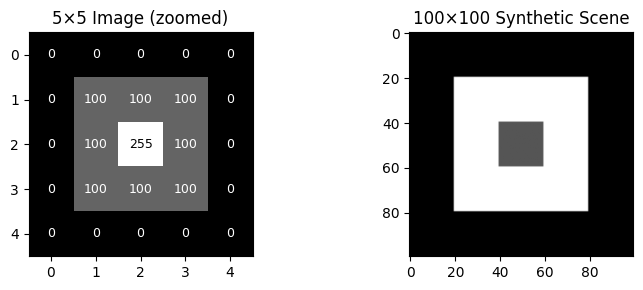

In [5]:
# A tiny 5x5 grayscale image — each number is a pixel brightness
tiny = np.array([
    [  0,   0,   0,   0,   0],
    [  0, 100, 100, 100,   0],
    [  0, 100, 255, 100,   0],
    [  0, 100, 100, 100,   0],
    [  0,   0,   0,   0,   0],
], dtype=np.uint8)

print(f"Shape: {tiny.shape}  dtype: {tiny.dtype}")
print(f"Pixel at (2,2): {tiny[2, 2]}  (brightest)")
print(f"Pixel at (0,0): {tiny[0, 0]}  (black)")

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(tiny, cmap="gray", vmin=0, vmax=255)
axes[0].set_title("5×5 Image (zoomed)")
# Annotate pixel values
for r in range(5):
    for c in range(5):
        color = "white" if tiny[r, c] < 128 else "black"
        axes[0].text(c, r, str(tiny[r, c]), ha="center", va="center",
                     fontsize=9, color=color)

# A larger synthetic scene
scene = np.zeros((100, 100), dtype=np.uint8)
scene[20:80, 20:80] = 180   # bright square
scene[40:60, 40:60] = 60    # darker inner square
axes[1].imshow(scene, cmap="gray")
axes[1].set_title("100×100 Synthetic Scene")
plt.tight_layout()
plt.show()

Windmill shape: (448, 300)  dtype: uint8
Image is already grayscale — skipping color conversion.


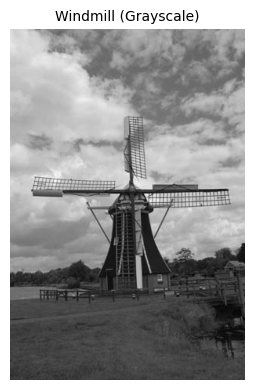

In [6]:
# Load a real image (windmill) to see a natural photograph as an array
import pathlib

workspace = pathlib.Path.cwd()
while not (workspace / "MODULE.bazel").exists():
    if workspace == workspace.parent:
        raise RuntimeError("Cannot find workspace root")
    workspace = workspace.parent

windmill_path = workspace / "resources" / "windmill.jpg"
windmill = plt.imread(str(windmill_path))
print(f"Windmill shape: {windmill.shape}  dtype: {windmill.dtype}")

# Convert to grayscale using the standard luminance formula
def rgb_to_gray(img):
    """Convert RGB uint8 image to grayscale float64."""
    return 0.2989 * img[:,:,0] + 0.5870 * img[:,:,1] + 0.1140 * img[:,:,2]

if windmill.ndim == 3:
    windmill_gray = rgb_to_gray(windmill).astype(np.uint8)
    show_images([windmill, windmill_gray], ["Windmill (Color)", "Windmill (Grayscale)"])
else:
    # Image is already single-channel (grayscale JPEG)
    windmill_gray = windmill
    print("Image is already grayscale — skipping color conversion.")
    show_images([windmill_gray], ["Windmill (Grayscale)"])

### Key Takeaways

- Images are NumPy arrays; pixels are array elements.
- `uint8` stores values 0–255 (0 = black, 255 = white).
- Color images have 3 channels; grayscale images have 1.
- Coordinate convention: `image[row, col]` where row = y, col = x.

### Exercise 1.1 — Slicing and Cropping

1. Create a 50×50 crop of the windmill image centered at row=150, col=200.
2. Print the mean pixel value of the crop.
3. Display the crop.

In [ ]:
# TODO: crop the windmill_gray image and display it
# crop = windmill_gray[...]
# print(f"Mean: {crop.mean():.1f}")
# show_images([crop], ["Cropped Region"])

**Solution**

Crop shape: (50, 50), Mean: 189.9


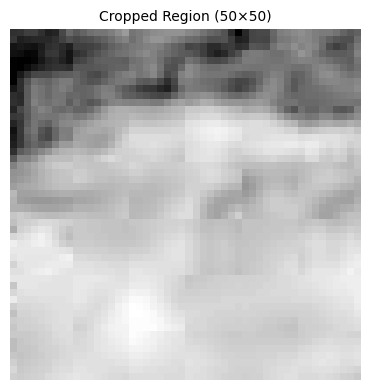

In [7]:
crop = windmill_gray[125:175, 175:225]
print(f"Crop shape: {crop.shape}, Mean: {crop.mean():.1f}")
show_images([crop], ["Cropped Region (50×50)"])

We used NumPy array slicing `[row_start:row_end, col_start:col_end]` to
extract a 50×50 patch centered at (150, 200). The mean gives us a rough
sense of the region's brightness.

### Exercise 1.2 — Data Types

1. Convert `windmill_gray` to `float32` with values in [0.0, 1.0].
2. Verify the min and max are 0.0 and 1.0 (approximately).
3. Convert back to `uint8` and check that pixel values are preserved.

In [ ]:
# TODO: type conversion
# float_img = ...
# back_to_uint8 = ...

**Solution**

In [8]:
float_img = windmill_gray.astype(np.float32) / 255.0
print(f"Float range: [{float_img.min():.3f}, {float_img.max():.3f}]")

back_to_uint8 = (float_img * 255).astype(np.uint8)
print(f"Round-trip match: {np.array_equal(windmill_gray, back_to_uint8)}")

Float range: [0.016, 0.984]
Round-trip match: True


Dividing by 255 normalizes uint8 to [0, 1] float. Multiplying back and
casting to uint8 recovers the original (with possible rounding for
intermediate floats).

---
## 2. Image Gradients

A **gradient** measures how quickly pixel values change. It has two components:

- **$G_x$** — rate of change in the horizontal (x) direction
- **$G_y$** — rate of change in the vertical (y) direction

From these we compute:

- **Magnitude:** $|\nabla I| = \sqrt{G_x^2 + G_y^2}$ — edge strength
- **Direction:** $\theta = \arctan2(G_y, G_x)$ — edge orientation

Gradients are computed by convolving the image with small **kernels**.
The most common is the **Sobel** operator:

$$K_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}
\qquad
K_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}$$

In [9]:
# --- Manual convolution on a small synthetic step edge ---
step_edge = np.array([
    [  0,   0,   0, 200, 200, 200],
    [  0,   0,   0, 200, 200, 200],
    [  0,   0,   0, 200, 200, 200],
    [  0,   0,   0, 200, 200, 200],
    [  0,   0,   0, 200, 200, 200],
    [  0,   0,   0, 200, 200, 200],
], dtype=np.float64)

# Sobel kernels
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)
Ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float64)

def convolve2d_valid(img, kernel):
    """Simple 2D convolution (valid region only)."""
    kh, kw = kernel.shape
    ih, iw = img.shape
    out = np.zeros((ih - kh + 1, iw - kw + 1))
    for r in range(out.shape[0]):
        for c in range(out.shape[1]):
            patch = img[r:r+kh, c:c+kw]
            out[r, c] = np.sum(patch * kernel)
    return out

Gx = convolve2d_valid(step_edge, Kx)
Gy = convolve2d_valid(step_edge, Ky)
mag = np.sqrt(Gx**2 + Gy**2)

print("Step edge (6×6):")
print(step_edge.astype(int))
print("\nGx (horizontal gradient, 4×4):")
print(Gx.astype(int))
print("\nGy (vertical gradient, 4×4):")
print(Gy.astype(int))
print("\nMagnitude:")
print(np.round(mag, 1))

Step edge (6×6):
[[  0   0   0 200 200 200]
 [  0   0   0 200 200 200]
 [  0   0   0 200 200 200]
 [  0   0   0 200 200 200]
 [  0   0   0 200 200 200]
 [  0   0   0 200 200 200]]

Gx (horizontal gradient, 4×4):
[[  0 800 800   0]
 [  0 800 800   0]
 [  0 800 800   0]
 [  0 800 800   0]]

Gy (vertical gradient, 4×4):
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]

Magnitude:
[[  0. 800. 800.   0.]
 [  0. 800. 800.   0.]
 [  0. 800. 800.   0.]
 [  0. 800. 800.   0.]]


Notice how $G_x$ is large (800) at the vertical edge between 0 and 200 values,
while $G_y$ is 0 everywhere — the edge runs horizontally in the array so
there's no vertical brightness change.

Let's apply this to a real image:

In [10]:
from scipy.signal import convolve2d

# Compute Sobel gradients on the windmill
wm_float = windmill_gray.astype(np.float64)
gx = convolve2d(wm_float, Kx, mode="same", boundary="symm")
gy = convolve2d(wm_float, Ky, mode="same", boundary="symm")
magnitude = np.sqrt(gx**2 + gy**2)
direction = np.arctan2(gy, gx)

show_images(
    [windmill_gray, magnitude, direction],
    ["Original", "Gradient Magnitude", "Gradient Direction"],
    cmap="gray"
)

ModuleNotFoundError: No module named 'scipy'

### Key Takeaways

- Gradients detect **where brightness changes** — they highlight edges.
- **Magnitude** tells us edge strength; **direction** tells us edge orientation.
- The Sobel kernel weights the center row/column more heavily for noise robustness.
- Other kernels exist: Scharr (better rotational symmetry), Prewitt (simpler).

### Exercise 2.1 — Prewitt Kernel

The **Prewitt** operator uses uniform weights:

$$K_x^{\text{Prewitt}} = \begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix}$$

1. Define the Prewitt $K_x$ and $K_y$ kernels.
2. Apply them to `windmill_gray`.
3. Compute and display the magnitude. How does it compare to Sobel?

In [ ]:
# TODO: define Prewitt kernels, compute gradients, display magnitude
# Kx_prewitt = ...
# Ky_prewitt = ...

**Solution**

In [ ]:
Kx_prewitt = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float64)
Ky_prewitt = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float64)

gx_p = convolve2d(wm_float, Kx_prewitt, mode="same", boundary="symm")
gy_p = convolve2d(wm_float, Ky_prewitt, mode="same", boundary="symm")
mag_prewitt = np.sqrt(gx_p**2 + gy_p**2)

show_images(
    [magnitude, mag_prewitt],
    ["Sobel Magnitude", "Prewitt Magnitude"]
)

Prewitt produces similar results but with slightly different edge emphasis.
Sobel's center-weighted kernel is more robust to noise; Prewitt is simpler
and treats all three rows/columns equally.

### Exercise 2.2 — Gradient Profile

1. Extract a single **row** from the windmill grayscale image (e.g., row 150).
2. Plot the pixel values along that row as a 1D signal.
3. Compute the finite difference (gradient approximation): `diff[i] = row[i+1] - row[i]`.
4. Plot the gradient values. Where do peaks correspond to edges?

In [ ]:
# TODO: extract row, compute difference, plot both

**Solution**

In [ ]:
row = windmill_gray[150, :].astype(np.float64)
diff = np.diff(row)  # finite difference: row[i+1] - row[i]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(row, "k-", linewidth=0.8)
ax1.set_ylabel("Pixel value")
ax1.set_title("Row 150 — Intensity Profile")
ax1.grid(True, alpha=0.3)

ax2.plot(diff, "r-", linewidth=0.8)
ax2.axhline(0, color="gray", linestyle="--", linewidth=0.5)
ax2.set_ylabel("Gradient (diff)")
ax2.set_xlabel("Column")
ax2.set_title("Row 150 — 1D Gradient")
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Peaks in the gradient signal correspond to edges — places where brightness
changes sharply. Positive peaks are dark→light transitions; negative peaks
are light→dark transitions.

---
## 3. Edge Detection Concepts

Raw gradient magnitude contains **all** brightness changes, including noise.
Edge detection refines this into a clean edge map through three steps:

1. **Thresholding** — keep only pixels above a magnitude threshold
2. **Non-Maximum Suppression (NMS)** — thin edges to 1-pixel width
3. **Hysteresis** — use two thresholds to connect weak edges to strong ones

Let's visualize each step.

In [ ]:
# 1. Simple thresholding
mag_norm = magnitude / magnitude.max()  # normalize to [0, 1]

th_low = 0.05
th_high = 0.15

edges_low = mag_norm > th_low     # many edges, includes noise
edges_high = mag_norm > th_high   # fewer edges, misses weak ones

show_images(
    [mag_norm, edges_low.astype(float), edges_high.astype(float)],
    ["Normalized Magnitude", f"Threshold > {th_low}", f"Threshold > {th_high}"]
)

The low threshold captures details but also noise. The high threshold is
cleaner but loses legitimate edges. This is the **threshold dilemma**.

### Non-Maximum Suppression (NMS)

NMS keeps only the **local maxima** along the gradient direction:

- For each pixel, look at its two neighbors along the gradient direction.
- If the pixel's magnitude is not the largest of the three, suppress it (set to 0).
- This produces edges that are exactly 1 pixel wide.

Let's demonstrate on a synthetic 1D cross-section:

In [ ]:
# 1D NMS demonstration
signal = np.array([0, 1, 3, 7, 10, 8, 4, 1, 0, 2, 5, 9, 6, 2, 0], dtype=float)

# Simple 1D NMS: keep value only if it's > both neighbors
nms_result = np.zeros_like(signal)
for i in range(1, len(signal) - 1):
    if signal[i] >= signal[i-1] and signal[i] >= signal[i+1]:
        nms_result[i] = signal[i]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax1.bar(range(len(signal)), signal, color="steelblue", alpha=0.7)
ax1.set_title("Before NMS — broad edge response")
ax1.set_ylabel("Magnitude")

colors = ["tomato" if v > 0 else "lightgray" for v in nms_result]
ax2.bar(range(len(nms_result)), nms_result, color=colors, alpha=0.7)
ax2.set_title("After NMS — only local maxima remain")
ax2.set_ylabel("Magnitude")
ax2.set_xlabel("Position")
plt.tight_layout()
plt.show()

### Hysteresis Thresholding

Hysteresis uses **two thresholds** to get the best of both worlds:

- **High threshold** ($T_H$): pixels above this are **definitely edges** (seeds).
- **Low threshold** ($T_L$): pixels above this are edges **only if connected** to a seed.

This preserves weak but genuine edges while rejecting isolated noise.

```
pixel magnitude > T_H  →  strong edge (always kept)
T_L < magnitude ≤ T_H  →  weak edge (kept if connected to strong)
magnitude ≤ T_L         →  suppressed
```

In [ ]:
# Visualize the three zones on the windmill gradient
T_L, T_H = 0.04, 0.12

zones = np.zeros_like(mag_norm)
zones[mag_norm > T_L] = 0.5   # weak edges (gray)
zones[mag_norm > T_H] = 1.0   # strong edges (white)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].imshow(mag_norm, cmap="gray")
axes[0].set_title("Gradient Magnitude")
axes[1].imshow(zones, cmap="gray", vmin=0, vmax=1)
axes[1].set_title(f"Hysteresis Zones\nBlack=suppressed, Gray=weak, White=strong")
axes[2].imshow(edges_high.astype(float), cmap="gray")
axes[2].set_title(f"Strong Edges Only (>{T_H})")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

### Key Takeaways

- **Thresholding** alone cannot balance detail vs. noise.
- **NMS** thins thick gradient responses to 1-pixel edges.
- **Hysteresis** with two thresholds keeps connected weak edges.
- These steps form the foundation of the Canny edge detector and are used
  extensively in the LineExtraction library.

### Exercise 3.1 — Threshold Effect

1. Using `mag_norm` from above, create edge maps with 4 different thresholds:
   0.02, 0.05, 0.10, 0.20.
2. Display all 4 side by side.
3. Which threshold gives the best balance of detail vs. noise?

In [ ]:
# TODO: create 4 thresholded edge maps and display them

**Solution**

In [ ]:
thresholds = [0.02, 0.05, 0.10, 0.20]
edge_maps = [(mag_norm > t).astype(float) for t in thresholds]
titles = [f"Threshold = {t}" for t in thresholds]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, img, title in zip(axes, edge_maps, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()

Lower thresholds capture more detail but also more noise. Higher ones are
cleaner but miss weak structures. There is no single "best" threshold —
this is exactly why hysteresis with two thresholds works better.

---
## 4. Lines and Line Segments

### Line Representations

There are many ways to represent a line mathematically. The LineExtraction
library uses the **Hesse normal form**:

$$\vec{n} \cdot \vec{p} = d$$

where:
- $\vec{n} = (n_x, n_y)$ is the **unit normal** vector (perpendicular to the line)
- $d$ is the **signed distance** from the origin to the line
- A point $(x, y)$ lies on the line if $n_x \cdot x + n_y \cdot y = d$

### Line Segments

A **line segment** extends a line with two parameters:
- **Start** and **End** positions along the line direction
- Equivalently: two **endpoints** $(x_1, y_1)$ and $(x_2, y_2)$

### Useful Properties

| Property | Formula |
|----------|--------|
| Distance from point to line | $\text{dist} = n_x \cdot x + n_y \cdot y - d$ |
| Line direction | $\vec{d} = (-n_y, n_x)$ (perpendicular to normal) |
| Angle | $\theta = \arctan2(n_y, n_x)$ |
| Segment length | $\|\text{end} - \text{start}\|$ |

In [ ]:
# Visualize a line in Hesse normal form
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 6)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
ax.set_title("Hesse Normal Form: n·p = d")

# Define a line: normal = (0.6, 0.8), distance = 3
nx, ny, d = 0.6, 0.8, 3.0
# Line direction (perpendicular to normal)
dx, dy = -ny, nx

# Point on line closest to origin = n * d
foot_x, foot_y = nx * d, ny * d

# Draw the line
t = np.linspace(-5, 5, 100)
line_x = foot_x + dx * t
line_y = foot_y + dy * t
ax.plot(line_x, line_y, "b-", linewidth=2, label="Line")

# Draw normal vector from origin
ax.annotate("", xy=(foot_x, foot_y), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color="red", lw=2))
ax.text(foot_x/2 + 0.1, foot_y/2 - 0.2, f"d = {d}", color="red", fontsize=12)

# Mark origin and foot point
ax.plot(0, 0, "ko", markersize=8)
ax.text(0.1, -0.3, "Origin", fontsize=10)
ax.plot(foot_x, foot_y, "ro", markersize=8)
ax.text(foot_x + 0.1, foot_y + 0.2, "Closest point", fontsize=10)

# Show normal direction
ax.text(0.3, 1.5, f"n = ({nx}, {ny})", color="red", fontsize=11)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
# Line intersection example
def line_intersection(n1x, n1y, d1, n2x, n2y, d2):
    """Find intersection of two lines in Hesse normal form."""
    det = n1x * n2y - n1y * n2x
    if abs(det) < 1e-10:
        return None  # parallel lines
    x = (d1 * n2y - d2 * n1y) / det
    y = (n1x * d2 - n2x * d1) / det
    return x, y

# Two lines
line1 = (0.6, 0.8, 3.0)   # Same as above
line2 = (1.0, 0.0, 2.0)   # Vertical line at x=2

pt = line_intersection(*line1, *line2)
print(f"Intersection: ({pt[0]:.2f}, {pt[1]:.2f})")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 6)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

for i, (nx, ny, d) in enumerate([line1, line2]):
    dx, dy = -ny, nx
    foot_x, foot_y = nx * d, ny * d
    t = np.linspace(-10, 10, 100)
    ax.plot(foot_x + dx * t, foot_y + dy * t, linewidth=2,
            label=f"Line {i+1}: n=({nx},{ny}), d={d}")

ax.plot(pt[0], pt[1], "r*", markersize=15, label=f"Intersection ({pt[0]:.1f}, {pt[1]:.1f})")
ax.legend(loc="upper right")
ax.set_title("Line Intersection")
plt.tight_layout()
plt.show()

### Line Segments and Endpoints

A line segment adds a **start** and **end** position along the line direction.
It can also be defined by two **endpoints** $(x_1, y_1)$ and $(x_2, y_2)$,
from which the line parameters (normal, distance) are derived.

In [ ]:
# Line segment from endpoints
def segment_from_endpoints(x1, y1, x2, y2):
    """Compute line parameters from two endpoints."""
    dx, dy = x2 - x1, y2 - y1
    length = np.sqrt(dx**2 + dy**2)
    # Normal is perpendicular to direction
    nx, ny = -dy / length, dx / length
    d = nx * x1 + ny * y1
    return {"nx": nx, "ny": ny, "d": d, "length": length,
            "center": ((x1+x2)/2, (y1+y2)/2)}

seg = segment_from_endpoints(1, 1, 4, 5)
print(f"Normal: ({seg['nx']:.3f}, {seg['ny']:.3f})")
print(f"Distance: {seg['d']:.3f}")
print(f"Length: {seg['length']:.3f}")
print(f"Center: ({seg['center'][0]:.1f}, {seg['center'][1]:.1f})")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 6)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

# Draw segment
ax.plot([1, 4], [1, 5], "b-o", linewidth=3, markersize=8)
ax.text(1, 0.5, "(1,1)", fontsize=10)
ax.text(4.1, 5, "(4,5)", fontsize=10)

# Draw normal at center
cx, cy = seg["center"]
ax.annotate("", xy=(cx + seg["nx"], cy + seg["ny"]), xytext=(cx, cy),
            arrowprops=dict(arrowstyle="->", color="red", lw=2))
ax.text(cx + 0.2, cy - 0.5, f"length = {seg['length']:.1f}", fontsize=10, color="blue")

ax.set_title("Line Segment with Normal")
plt.tight_layout()
plt.show()

### Exercise 4.1 — Point-to-Line Distance

Given line 1 from above (normal = (0.6, 0.8), d = 3.0):

1. Compute the signed distance from the point (1, 1) to the line.
2. Compute the signed distance from the point (3, 3) to the line.
3. Which point is closer to the line? On which side of the line is each?

In [ ]:
# TODO: compute distances using the formula: dist = nx*x + ny*y - d

**Solution**

In [ ]:
nx, ny, d = 0.6, 0.8, 3.0

dist_11 = nx * 1 + ny * 1 - d
dist_33 = nx * 3 + ny * 3 - d

print(f"Distance from (1,1): {dist_11:.2f}")
print(f"Distance from (3,3): {dist_33:.2f}")
print(f"\n(1,1) is {'above' if dist_11 < 0 else 'below'} the line (negative = origin side)")
print(f"(3,3) is {'above' if dist_33 < 0 else 'below'} the line")
print(f"\n(1,1) is closer (|{dist_11:.2f}| < |{dist_33:.2f}|): {abs(dist_11) < abs(dist_33)}")

The signed distance is simply $n_x \cdot x + n_y \cdot y - d$. Negative means
the point is on the origin side of the line; positive means the far side.

### Exercise 4.2 — Intersection

1. Define two line segments: (0, 0)→(5, 5) and (0, 5)→(5, 0).
2. Compute line parameters for each.
3. Find their intersection point.
4. Plot both segments and mark the intersection.

In [ ]:
# TODO: define segments, compute intersection, plot

**Solution**

In [ ]:
s1 = segment_from_endpoints(0, 0, 5, 5)
s2 = segment_from_endpoints(0, 5, 5, 0)

pt = line_intersection(s1["nx"], s1["ny"], s1["d"],
                       s2["nx"], s2["ny"], s2["d"])
print(f"Intersection: ({pt[0]:.2f}, {pt[1]:.2f})")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 5], [0, 5], "b-o", linewidth=2, label="Segment 1")
ax.plot([0, 5], [5, 0], "g-o", linewidth=2, label="Segment 2")
ax.plot(pt[0], pt[1], "r*", markersize=15, label="Intersection")
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title("Two Crossing Segments")
plt.tight_layout()
plt.show()

The two diagonals cross at (2.5, 2.5) — the center of the 5×5 square.
We computed line parameters from endpoints, then found the intersection
using the 2×2 linear system defined by the two Hesse normal forms.

---
## 5. Line Segment Detection — Overview

**Line Segment Detection (LSD)** automatically finds straight line segments
in images. This is a critical building block for many vision tasks:

- Architectural analysis and reconstruction
- Vanishing point estimation
- Camera calibration
- Stereo matching
- Scene understanding

### Detector Taxonomy

Line segment detectors fall into three major categories:

| Category | Approach | Examples |
|----------|----------|---------|
| **Region-based** | Group pixels with similar gradient direction, then fit lines | Burns, LSD (Gioi), Connected Components |
| **Edge-based** | Detect edges first, then extract line segments from edge chains | Edge Drawing, Edge Linking, Edge Pattern |
| **Voting-based** | Each edge pixel votes for line parameters in parameter space | Hough Transform |

### Typical Pipeline

```
Input Image
    │
    ▼
Gradient Computation (Sobel, Scharr, Prewitt)
    │
    ▼
Edge Detection (NMS + thresholding)
    │
    ▼
Edge Grouping (segment linking, region growing, or voting)
    │
    ▼
Line Fitting (least squares, split & merge)
    │
    ▼
Line Segments
```

### Quality Criteria

How do we evaluate a line segment detector?

| Criterion | Description |
|-----------|-------------|
| **Completeness** | Does it find all lines in the image? |
| **Accuracy** | Are the detected endpoints/geometry correct? |
| **Speed** | How fast is the detection? |
| **Noise robustness** | How does performance degrade with noise? |
| **Parameter sensitivity** | How much tuning is required? |

In [ ]:
# Visual overview: what LSD produces
# Create a synthetic image with obvious line structures
canvas = np.zeros((200, 200), dtype=np.uint8)
# Horizontal line
canvas[50, 20:180] = 255
# Vertical line
canvas[30:170, 150] = 255
# Diagonal line
for i in range(140):
    r, c = 30 + i, 20 + i
    if 0 <= r < 200 and 0 <= c < 200:
        canvas[r, c] = 255
# Rectangle
canvas[120:160, 30:100] = 0
canvas[120, 30:100] = 255
canvas[160, 30:100] = 255
canvas[120:160, 30] = 255
canvas[120:160, 100] = 255

# Show what a detector should find
result_canvas = np.zeros((200, 200, 3), dtype=np.uint8)
result_canvas[:, :, 0] = canvas  # red channel = original
# Mark expected line segments with colored lines
segments = [
    ((20, 50), (180, 50), (0, 255, 0)),     # horizontal - green
    ((150, 30), (150, 170), (0, 255, 255)),  # vertical - cyan
    ((20, 30), (160, 170), (255, 255, 0)),   # diagonal - yellow
    ((30, 120), (100, 120), (255, 0, 255)),  # rect top - magenta
    ((30, 160), (100, 160), (255, 0, 255)),  # rect bottom
    ((30, 120), (30, 160), (255, 0, 255)),   # rect left
    ((100, 120), (100, 160), (255, 0, 255)), # rect right
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(canvas, cmap="gray")
axes[0].set_title("Input Image")

axes[1].imshow(np.zeros((200, 200, 3), dtype=np.uint8))
for (x1, y1), (x2, y2), color in segments:
    c = np.array(color) / 255
    axes[1].plot([x1, x2], [y1, y2], color=c, linewidth=2)
    axes[1].plot([x1, x2], [y1, y2], "o", color=c, markersize=4)
axes[1].set_title("Expected Line Segments")
axes[1].set_xlim(0, 200)
axes[1].set_ylim(200, 0)

for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

### Exercise 5.1 — Thinking About Detectors

Consider the synthetic image above. Answer these questions:

1. What challenges would a **simple threshold-based** approach face?
2. Why might the diagonal line be harder to detect accurately than the
   horizontal line?
3. For the rectangle: should a detector return 4 separate segments or
   recognize it as a closed shape? What are the trade-offs?

**Solution**

1. **Threshold-based approach:** A simple threshold finds edge *pixels* but
   has no concept of line segments. It cannot group co-linear pixels or
   determine endpoints. It would also fail at junctions where lines cross.

2. **Diagonal line difficulty:** Diagonal lines are drawn on a discrete pixel
   grid, so they have a staircase pattern. The gradient direction alternates
   between two values, making it harder for region-growing methods. Edge-based
   methods must handle the zigzag pattern, and endpoint localization is less
   precise.

3. **Rectangle segments vs. shape:** Returning 4 segments is more general and
   composable — downstream algorithms can reason about individual edges.
   Recognizing a closed shape is higher-level but loses individual segment
   information. Most LSD algorithms return individual segments; shape
   recognition is a separate step.

---
## Summary

You now understand the core concepts needed for the LineExtraction tutorials:

| Concept | Key Idea |
|---------|----------|
| Images as arrays | Pixels are numbers; shape = (H, W) or (H, W, 3) |
| Gradients | Measure brightness change; magnitude = edge strength |
| Edge detection | NMS + hysteresis produce clean 1-pixel edges |
| Lines | Hesse normal form: normal vector + origin distance |
| LSD | Automatically extract line segments from images |

**Next:** Open **Tutorial 1 — Library Fundamentals** (`tutorial_1_fundamentals.ipynb`)
to learn the LineExtraction Python API.